# Adversarial Example

This code demonstrates how to integrate adversarial training using the ART library with a simple CNN model trained on the MNIST dataset using PyTorch. It covers data loading, model definition, ART integration for adversarial attacks, adversarial example generation, training loop alternating between original and adversarial examples, evaluation on test sets, and visualization of training and test accuracies. This approach helps improve the robustness of the model against adversarial attacks, contributing to more reliable and secure AI systems.

In [1]:
!pip install art adversarial-robustness-toolbox torch torchvision --quiet

In [2]:
!pip install --upgrade adversarial-robustness-toolbox --quiet


## Import necessary libraries 

PyTorch for deep learning operations (torch), neural network modules (nn), optimization algorithms (optim), functional operations (F), data handling utilities from torchvision (datasets, transforms), data loading utilities (DataLoader, TensorDataset), and matplotlib for plotting (plt).

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Install the ART library if you haven't already
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Matplotlib is building the font cache; this may take a moment.


## Data Loading

- transforms.Compose: Compose transformations to apply to the MNIST dataset. Here, it converts images to PyTorch tensors (ToTensor()) and normalizes them to have a mean of 0.5 and standard deviation of 0.5 (Normalize((0.5,), (0.5,)))
- datasets.MNIST: Load MNIST dataset, both training and test sets, applying the defined transformations (transform)
- DataLoader: Create data loaders for training and test datasets, which handle batching, shuffling, and loading of data batches (batch_size=128)


In [ ]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Architecture

- Define a simple convolutional neural network (SimpleCNN) using PyTorch's nn.Module

        1. __init__: Define layers including two convolutional layers (conv1, conv2) followed by max pooling, and two  fully connected layers (fc1, fc2).
        
        2. forward: Define the forward pass of the network where input x passes through convolutional layers with ReLU activation, max pooling, and fully connected layers with ReLU activation for feature extraction and classification.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Initialization

- Initialize an instance of SimpleCNN as model
- Define CrossEntropyLoss as the loss function (criterion), which is suitable for multi-class classification tasks
- Use the Adam optimizer (optim.Adam) to optimize model parameters (model.parameters()) with a learning rate of 0.001

## ART Integration
- Use PyTorchClassifier from ART to wrap the PyTorch model (model)
- Parameters include model, clip values for input normalization (clip_values=(0, 1)), loss function (loss=criterion), optimizer (optimizer), input shape (input_shape=(1, 28, 28) for MNIST images), and number of classes (nb_classes=10 for MNIST digits 0-9).

In [ ]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Wrap the PyTorch model with ART's PyTorchClassifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

## Adversarial Attack:

- Use ProjectedGradientDescent from ART as an attack method (attack) to generate adversarial examples (attack.generate)
- Parameters include the ART classifier (estimator=classifier), perturbation size (eps=0.3), step size (eps_step=0.01), and maximum iterations (max_iter=40)

In [ ]:

# Create the ProjectedGradientDescent attack object
attack = ProjectedGradientDescent(estimator=classifier, eps=0.3, eps_step=0.01, max_iter=40)

## Data Conversion

- Convert PyTorch tensors to numpy arrays (x_train, x_test) for attack generation and adversarial training

In [ ]:
# Convert the data to ART format for attack generation
x_train = np.array([data[0].numpy() for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])
x_test = np.array([data[0].numpy() for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

In [ ]:

# Generate adversarial examples for the training and test sets
x_train_adv = attack.generate(x=x_train)
x_test_adv = attack.generate(x=x_test)

PGD - Batches:   0%|          | 0/1875 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## Training and Evaluation

- Epoch Loop: Iterate over a fixed number of epochs (epochs=5)

- Training Phase

1. Original Examples: Train the model on original examples (train_loader) by calculating loss (criterion), computing gradients (loss.backward()), and updating model parameters (optimizer.step())

2. Adversarial Examples: Evaluate training accuracy on both original and adversarial examples (x_train, x_train_adv). Use torch.tensor to convert numpy arrays to PyTorch tensors, perform forward pass (model(data)), predict classes (torch.argmax), and calculate accuracy

- Adversarial Training

1. Convert adversarial examples to TensorDataset (adv_dataset) and use DataLoader (adv_loader) for adversarial training (for batch_idx, (data, target) in enumerate(adv_loader))

- Test Phase

1. Original Examples: Evaluate test accuracy on original examples (test_loader)

2. Adversarial Examples: Evaluate test accuracy on adversarial examples (x_test, x_test_adv)

In [ ]:
# Adversarial training: train on both original and adversarial examples
epochs = 5
batch_size = 32

train_acc_orig = []
train_acc_adv = []
test_acc_orig = []
test_acc_adv = []

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    
    # Train on original examples
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    # Evaluate training accuracy on original and adversarial examples
    model.eval()
    with torch.no_grad():
        # Original examples
        train_preds_orig = torch.argmax(model(torch.tensor(x_train).float()), dim=1).numpy()
        train_acc_orig.append(np.mean(train_preds_orig == y_train))
        
        # Adversarial examples
        train_preds_adv = torch.argmax(model(torch.tensor(x_train_adv).float()), dim=1).numpy()
        train_acc_adv.append(np.mean(train_preds_adv == y_train))
    
    # Train on adversarial examples
    adv_dataset = TensorDataset(torch.tensor(x_train_adv).float(), torch.tensor(y_train))
    adv_loader = DataLoader(adv_dataset, batch_size=batch_size, shuffle=True)
    for batch_idx, (data, target) in enumerate(adv_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    # Evaluate test accuracy on original and adversarial examples
    model.eval()
    with torch.no_grad():
        # Original examples
        test_preds_orig = torch.argmax(model(torch.tensor(x_test).float()), dim=1).numpy()
        test_acc_orig.append(np.mean(test_preds_orig == y_test))
        
        # Adversarial examples
        test_preds_adv = torch.argmax(model(torch.tensor(x_test_adv).float()), dim=1).numpy()
        test_acc_adv.append(np.mean(test_preds_adv == y_test))

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


## Visualization

- Plot training and test accuracies (train_acc_orig, train_acc_adv, test_acc_orig, test_acc_adv) over epochs (epochs_range) using matplotlib (plt)

- Customize plot with labels, title, markers, and legend to visualize the performance of the model on original and adversarial examples

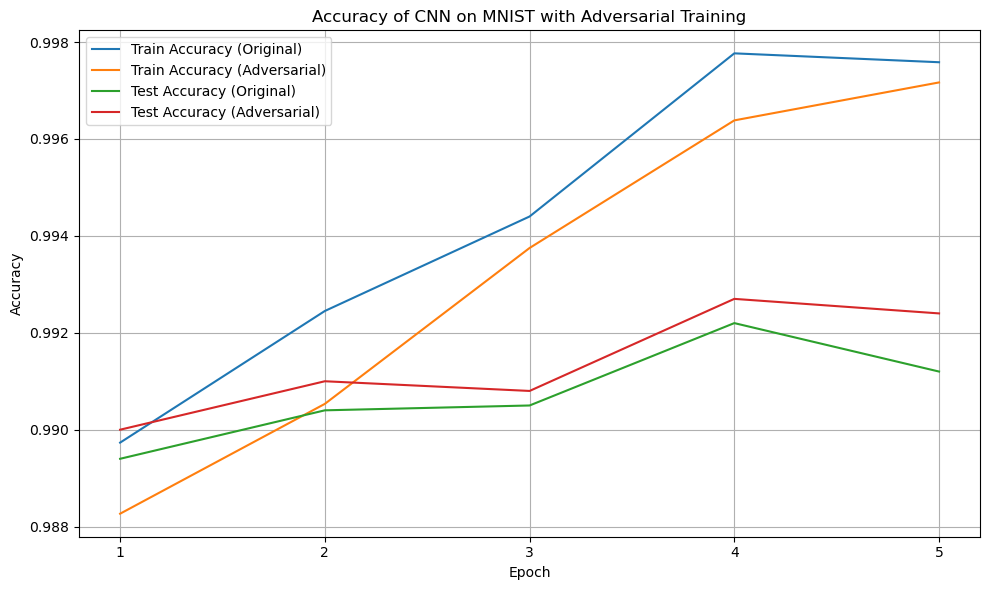

In [12]:

# Plotting the results
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_acc_orig, label='Train Accuracy (Original)')
plt.plot(epochs_range, train_acc_adv, label='Train Accuracy (Adversarial)')
plt.plot(epochs_range, test_acc_orig, label='Test Accuracy (Original)')
plt.plot(epochs_range, test_acc_adv, label='Test Accuracy (Adversarial)')
plt.title('Accuracy of CNN on MNIST with Adversarial Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs_range)
plt.tight_layout()

# Save plot in high resolution (300 dpi) as PNG file
plt.savefig('accuracy_mnist_adversarial.png', dpi=300)
plt.show()
